# Imports and seeding

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import seed_everything
from config import *

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'

In [3]:
seed_everything(SEED)

# Load data

In [4]:
df_train = pd.read_csv(CSV_TRAIN, index_col=0)
df_test = pd.read_csv(CSV_TEST, index_col=0)

# Dataframes

Let's take a look at the data

In [5]:
df_train.head()

,image_id,emotion
0,7b8b3a37-3dab-4d0a-af96-38c1be4a1983,6
1,7551243c-2334-497c-9cde-b36810eb9c91,6
2,dd3db60d-7b63-4ff1-84e2-90a8ca63d51c,0
3,0f0a2c1b-9660-4855-9c40-4a34e5b2ed09,2
4,9b60bd4e-09dc-4118-bb05-df594c954993,2


In [6]:
df_test.head()

,image_id,emotion
0,fadcda8b-5d0a-4340-825b-6747257b368a,NaN
1,485a2655-d827-4db0-b2d4-ca8ee1d27b0f,NaN
2,bb9c4ed1-b7b8-4a1f-acd4-7ac02590ad2a,NaN
3,9b9635a4-481e-4a07-a0ca-1ab4ac843cc5,NaN
4,f0eda54c-814d-49d9-b896-5829094a47a5,NaN


We check if there are seven emotions as specified in the task sheet

In [7]:
emotions = df_train['emotion'].value_counts(sort=False)
print(emotions)

0    4198
1     466
2    4320
3    7682
4    5177
5    3401
6    5259
Name: emotion, dtype: int64


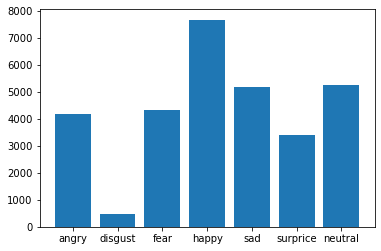

In [8]:
plt.bar(range(len(emotions)), emotions, tick_label=['angry', 'disgust', 'fear', 'happy', 'sad', 'surprice', 'neutral'])
plt.show()

We see that there indeed are seven emotions. We also notice however that there is a big class imbalance, which we will have to deal with later on.

Number of images in each split

In [9]:
print(f"Number of training images: {len(df_train)}")
print(f"Number of test images: {len(df_test)}")

Number of training images: 30503
Number of test images: 4038


Checking for missing values

In [10]:
print(f"Missing values in train: {df_train.isnull().values.any()}")
print(f"Missing values in test: {df_test['image_id'].isnull().values.any()}")

Missing values in train: False
Missing values in test: False


# Images

We start by defining some variables that we found in the section above and in the task sheet

In [ ]:
n_emotions = len(df_train['emotion'].value_counts())
n_train = len(df_train)
n_test = len(df_test)
image_shape = (48, 48)
emotion_dict = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprice', 6: 'neutral'}

In [12]:
emotion_dict.values()

dict_values(['angry', 'disgust', 'fear', 'happy', 'sad', 'surprice', 'neutral'])

Plot 10 random train and test images

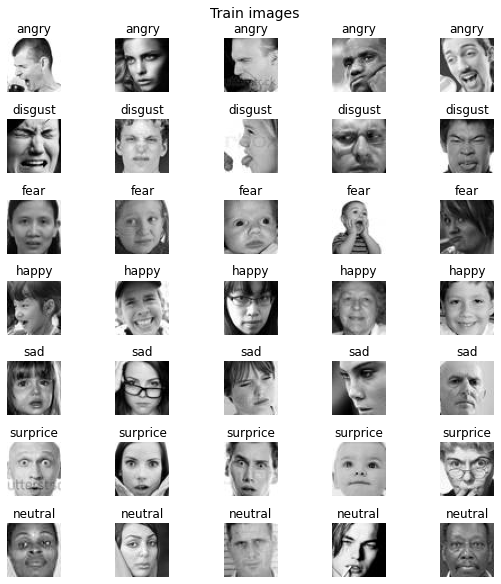

In [13]:
fig, ax = plt.subplots(n_emotions, 5, figsize=(8,8))

for i in range(n_emotions):
    df_emotion = df_train[df_train['emotion'] == i]
    for k in range(5):
        image_index = np.random.randint(len(df_emotion))
        impath = os.path.join(IMAGE_DIRECTORY_TRAIN, df_emotion['image_id'].iloc[image_index] + '.jpg')
        image = plt.imread(impath)
        ax[i, k].imshow(image, cmap='gray')
        ax[i, k].set_title(emotion_dict[i])
        ax[i, k].axis('off')

plt.figtext(0.43, 0.99, "Train images", size=14)
plt.tight_layout()
plt.show()

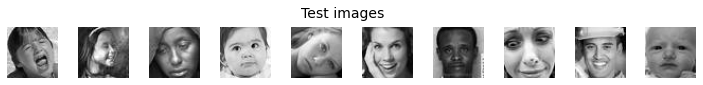

In [14]:
fig, ax = plt.subplots(1, 10, figsize=(10,1))

for i in range(10):
    image_index = np.random.randint(n_test)
    impath = os.path.join(IMAGE_DIRECTORY_TEST, df_test['image_id'].iloc[image_index] + '.jpg')
    image = plt.imread(impath)
    ax[i].imshow(image, cmap='gray')
    ax[i].axis('off')

plt.figtext(0.43, 0.99, "Test images", size=14)
plt.tight_layout()
plt.show()

# Eigenfaces

By loading all in the images in numpy array and flattening them out such that each pixel is interpreted as a feature, we can do principal component analysis (PCA) on each of the seven emotion.

The eigenvector corresponding to the largest eigenvalue can then be interpreted as the iconic image for that particular emotion.

In [15]:
eigenfaces = []

for i in range(n_emotions):
    # get every row of the df where emotion==i
    emotion_df = df_train[df_train['emotion'] == i]
    n_samples = len(emotion_df)
    
    emotion_images = np.zeros((n_samples, image_shape[0]*image_shape[1]))
    
    # loop over each image_id in emotion_df and add the flattened image to emotion_images
    for k in range(n_samples):
        image_id = df_train['image_id'].iloc[k]
        image_path = os.path.join(IMAGE_DIRECTORY_TRAIN, image_id + '.jpg')
        image = plt.imread(image_path)
        image = image.copy()
        image = image / 255. # normalizing the image
        image = image.flatten()
        emotion_images[k, :] = image
    
    cov = np.cov(emotion_images, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    eigenfaces.append(eigenvectors[:, -1])

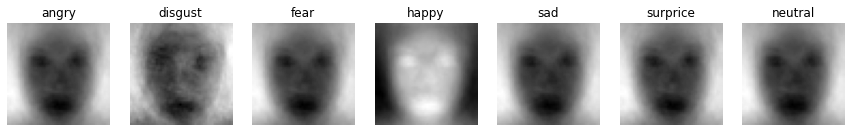

In [16]:
fig, ax = plt.subplots(1, n_emotions, figsize=(15, 10))
for i, eigenface in enumerate(eigenfaces):
    eigenface = eigenface.reshape(image_shape[0], image_shape[1])
    ax[i].imshow(eigenface, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'{emotion_dict[i]}')

plt.show()

The images look very much a like with the exception of 'happy' which is very bright. Without the labels, it seems impossible to infer which emotion is portrayed.

# PCA

By doing PCA on the entire dataset, we can select the two biggest principal components and project the images onto them.

In [17]:
images = np.zeros((n_train, image_shape[0]*image_shape[1]))

for i in range(n_train):
    image_id = df_train['image_id'].iloc[i]
    image_path = os.path.join(IMAGE_DIRECTORY_TRAIN, image_id + '.jpg')
    image = plt.imread(image_path)
    image = image.copy()
    image = image / 255. # normalizing the image
    image = image.flatten()
    images[i, :] = image

cov = np.cov(images, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eigh(cov)

In [18]:
eigenvalues = eigenvalues[::-1]
eigenvectors = eigenvectors[:, ::-1]

V = eigenvectors[:, :2]
projections = images @ V

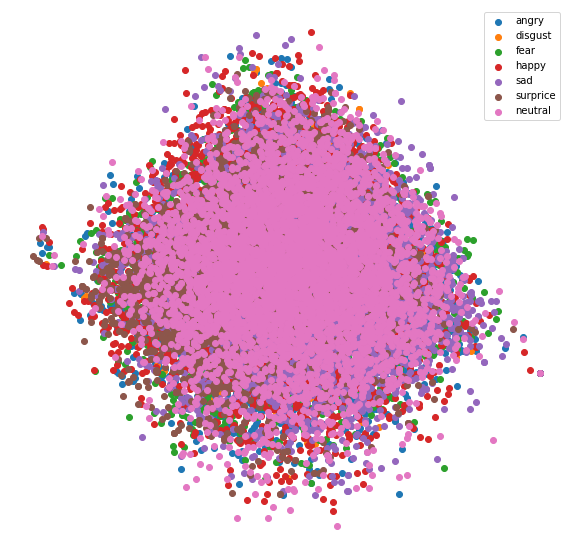

In [19]:
fig = plt.figure(figsize=(10, 10))
for i in range(n_emotions):
    plt.scatter(projections[df_train['emotion'] == i][:, 0], projections[df_train['emotion'] == i][:, 1], label=emotion_dict[i])
plt.legend()
plt.axis('off')
plt.show()

We can then take a look at the explained variance

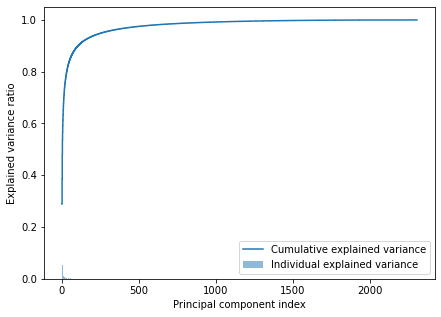

In [20]:
total_var = sum(eigenvalues)
var_exp = eigenvalues / total_var
cum_var_exp  = np.cumsum(var_exp)

fig = plt.figure(figsize=(7, 5))
plt.bar(range(1, len(var_exp)+1), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(var_exp)+1), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

Lastly we examine how many eigenvectors are needed to capture various percentage of the total variance.

In [21]:
variances = [0.8, 0.9, 0.99]
for i in variances:
    idx = np.nonzero(cum_var_exp >= i)[0][0]
    
    print(f"Least number of eigenvectors need for capturing {i*100}% variance: {idx}")

Least number of eigenvectors need for capturing 80.0% variance: 31
Least number of eigenvectors need for capturing 90.0% variance: 104
Least number of eigenvectors need for capturing 99.0% variance: 894
